# Feature Engineering and Classification of Disaster Images

**Notes to Self**
* Remember to limit the classes to only the ones you are using
* Only have ONE label2id and 1 id2label dictionary so you never have conflicts with label differences when switching between models

##### Setup

In [1]:
import os
# temporarily set this environment variable to avoid issues with duplicate libraries when using Pytorch
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

home = os.path.expanduser("~")
this_dir = os.path.join(home, "SURE-2025")
os.chdir(this_dir) # ensure we are in the correct directory

In [2]:
# setting seeds and the device
import torch
import random
import numpy as np

SEED = 9
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

if torch.cuda.is_available():
    device = torch.device("cuda", torch.cuda.current_device())
    print('using cuda')
else:
    device = torch.device("cpu")
    print('using cpu')

using cuda


## Data

In this project, we are using the CrisisMMD dataset. There are several advantages of using CrisisMMD. 
* each tweet has at least one image associated with it, so we can train text and image models that work on the same distribution
* three types of labels are available: informative, humanitarian, severity (we are using the humanitarian labels)
* ***continue later***

But there are some disadvantages worth mentioning as well. 
* the humanitarian classes we use here are imbalanced
* images and tweets can have different labels, which can complicate classification

We can begin visualizing the data by placing it into a pandas DataFrame. After, we will place it in a custom Pytorch Dataset. 

**Note**: after downloading CrisisMMD v2, I placed it directly in my user folder for the most direct access. 

In [3]:
from pathlib import Path
import os
import pandas as pd

# access the data from the folders
home = Path(os.path.expanduser('~'))
dir = home / 'CrisisMMD_v2.0' / 'CrisisMMD_v2.0' 
datasplit_dir = dir / 'crisismmd_datasplit_all' / 'crisismmd_datasplit_all'
train_data = pd.read_csv(datasplit_dir / 'task_humanitarian_text_img_train.tsv', sep='\t')

In [4]:
train_data.head(3)

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative
1,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive


In [5]:
train_data['label_image'].value_counts()

label_image
not_humanitarian                          6565
infrastructure_and_utility_damage         2761
other_relevant_information                1860
rescue_volunteering_or_donation_effort    1694
affected_individuals                       397
vehicle_damage                             230
injured_or_dead_people                      92
missing_or_found_people                      9
Name: count, dtype: int64

Now that we know what the data looks like, we can visualize the images by accessing the paths in the DataFrame. (*Warning*: the dataset contains some sensitive images)

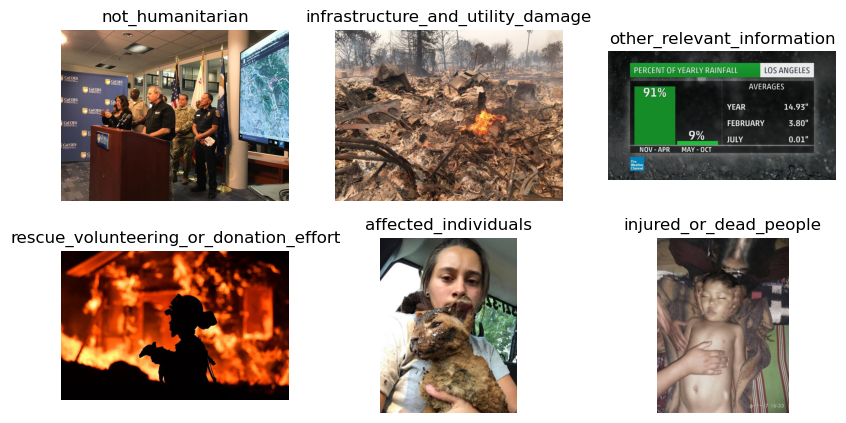

In [6]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# Visualize 6 images from the training set of the classes we are interested in
classes = [label for label in 
               train_data['label_image'].value_counts().reset_index()['label_image'].to_dict().values()
               if label not in ['vehicle_damage', 'missing_or_found_people']]

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
# i goes 0 through 5
for i, label in enumerate(classes):
    ax = axes[i // 3, i % 3]
    img_path = train_data[train_data['label_image'] == label].iloc[0]['image']
    img = Image.open(dir / img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.show()

## Feature Engineering - Traditional Features

We will want to see how several different combinations of transformations affect the images. Those transformations are Gabor filters, Hu Moments, color histograms, and local binary patterns. These are considered traditional image feature-engineering techniques. The goal with applying the transformations is to promote intra-class similarity and inter-class variance. 

### Gabor filters

Gabor filters are meant to mimic the way that humans see images. They are commonly used for feature discrimination, texture analysis, and edge detection. They represent a Gaussian envelope modified by a sinusoidal function. They have been shown to have good results on complex tasks, such as facial images.

In [7]:
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.color import rgb2gray

# TODO: learn more about optimal params and features to extract from gabor filters
# computes features that can be input to a classifier
def compute_gabor_feats(image, kernels):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for i, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[i, 0] = filtered.mean()
        feats[i, 1] = filtered.var()
        feats[i, 3] = np.linalg.norm(filtered) # computes the L2 norm/magnitude of the filtered image
        feats[i, 2] = filtered.std()
    return feats

# for convolving the gabor kernel with the images to see response
# input is a ndarray image and a kernel
def power(image, kernel):
    # Normalize (and convert to greyscale) images for better comparison.
    # The range of a floating point image is [0.0, 1.0] or [-1.0, 1.0] 
    image = img_as_float(rgb2gray(image))
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(input=image, weights=np.real(kernel), mode='wrap') **2
        + ndi.convolve(image, np.imag(kernel), mode='wrap') ** 2)*255


# example kernel creation 

kernels = []
for theta in range(4):
    theta = theta / 4.0 * np.pi 
    for sigma in (1,3):
        for freq in (0.05,.25):
            kernel = np.real(
                gabor_kernel(freq, theta=theta, sigma_x=sigma, sigma_y=sigma)
            )
            kernels.append(kernel)

for kernel in kernels:
    print(kernel.shape)

(7, 7)
(7, 7)
(19, 19)
(19, 19)
(7, 7)
(7, 7)
(15, 15)
(15, 15)
(7, 7)
(7, 7)
(19, 19)
(19, 19)
(7, 7)
(7, 7)
(15, 15)
(15, 15)


In [8]:
shrink = (slice(0, None, 3), slice(0, None, 3)) # to shrink image size before using the kernel
imgs_ = []
for i, label in enumerate(classes):
    img_path = train_data[train_data['label_image'] == label].iloc[0]['image']
    img = Image.open(dir / img_path)
    
    img = img_as_float(np.array(img)[shrink])
    imgs_.append(img)


powers = []
for img in imgs_:
    for kernel in kernels:
        powers.append(power(img, kernel))


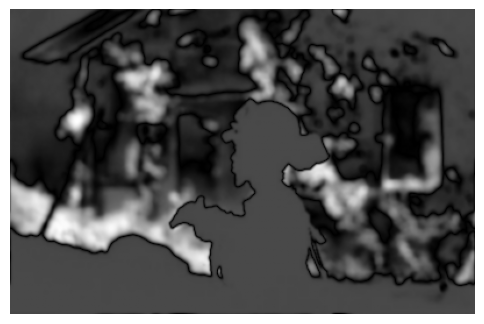

In [9]:
# example of img transformed by kernel
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_axis_off()
ax.imshow(powers[48], cmap='grey')

In [10]:
import cv2 

label = classes[3] # rescue, volunteer, or donation

image = train_data[train_data['label_image'] == label].iloc[0]['image']

image = cv2.normalize(rgb2gray(np.array(Image.open(dir / image))), None, 0, 1, cv2.NORM_MINMAX)

feats = compute_gabor_feats(image, kernels)

# feats describing mean, variance, magnitude, and standard deviation of the filtered image
# each row is a kernel, each column is a feature
feats.shape

(16, 4)

### Hu Moments
Image moments are the weighted average of pixel intensities. For a binary image (black and white), it would just be the number of white pixels. Central moments are similar but they are translation invariant, so they remain the same regardless of where a shape occurs in the image. From this, Hu Moments are calculated.  

[Hu Moments](https://learnopencv.com/shape-matching-using-hu-moments-c-python/) are a set of 7 numbers that are invariant (don't change) to image transformations. The first 6 moments have been proved to be invariant to translation, scale, and rotation, and reflection. While the 7th moment’s sign changes for image reflection.

Because each of the moments are of very different scales, a log transform should be used to bring them to a comparable range. 

### Color Histograms

Color histograms represent the distribution of colors in an image. 

A tutorial for visualizing color histograms can be found [here](https://pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/). 

##### 1D Color Histogram

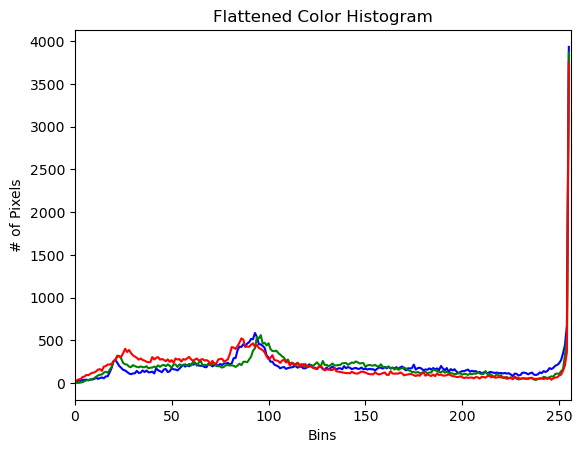

In [11]:
test_img = np.array(Image.open(dir / train_data[train_data['label_image'] == 
                                 'affected_individuals'].iloc[0]['image']
                                 ).resize((224, 224))).astype(np.uint8)

test_cv2 = Image.fromarray(test_img)
test_cv2.show()

test_img = cv2.normalize(test_img, None, 0, 255, cv2.NORM_MINMAX)

chans = cv2.split(test_img) # b g r
colors = ['b', 'g', 'r']

plt.figure()
plt.title('Flattened Color Histogram')
plt.xlabel('Bins')
plt.ylabel('# of Pixels')



for (chan, color) in zip(chans, colors):
    hist = cv2.calcHist([chan], channels=[0], mask=None, histSize=[256], ranges=[0,256])
    plt.plot(hist, color=color)
    plt.xlim([0, 256])



##### 2D Color Histograms
2D color histograms will show us how many pixels have X number of color1 and Y number of color2 pixels, for example. 

**Note**: We used 256 bins above to best visualize the pixel intensity per channel, but we shorten it to 32 bins for more practical purposes (3 256x256 matrices is a lot of data points!). 

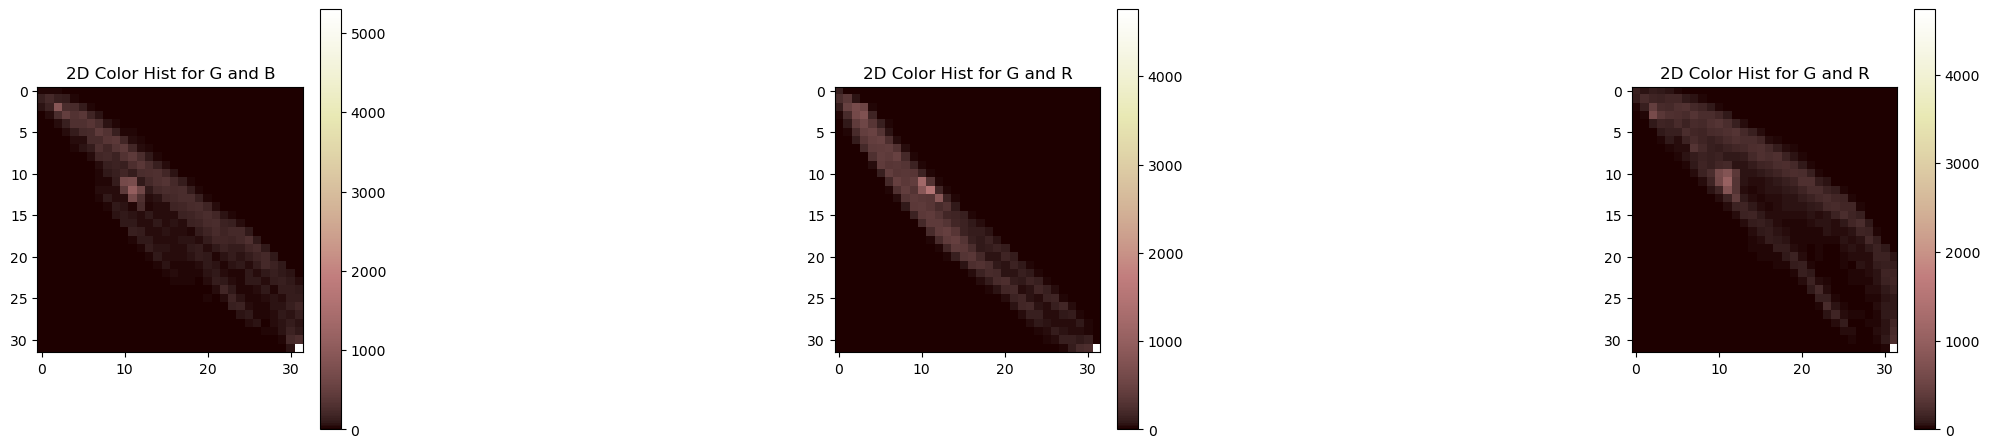

In [12]:
# colors: b, g, r

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(2, 6, 1)

# green and blue
hist = cv2.calcHist([chans[1], chans[0]], [0, 1], None, [32, 32], [0,256]*2)
p = ax.imshow(hist, interpolation='nearest', cmap='pink')
ax.set_title('2D Color Hist for G and B')
plt.colorbar(p, shrink=.4)


# green and red
ax = fig.add_subplot(2, 6, 3)
hist = cv2.calcHist([chans[1], chans[2]], [0, 1], None, [32, 32], [0, 256]*2)
p = ax.imshow(hist, interpolation='nearest', cmap='pink')
ax.set_title('2D Color Hist for G and R')
plt.colorbar(p, shrink=.4)


# red and blue
ax = fig.add_subplot(2, 6, 5)
hist = cv2.calcHist([chans[2], chans[0]], [0, 1], None, [32, 32], [0, 256]*2)
p = ax.imshow(hist, interpolation='nearest', cmap='pink')
ax.set_title('2D Color Hist for G and R')
plt.colorbar(p, shrink=.4)




### Local Binary Patterns

LBPs are a powerful texture descriptor that describes the local representation of texture. They work by comparing the intensity of a central pixel with the intensity of surrounding pixels. It is efficient and invariant to rotation and scale. However it is sensitive to noise in images. 

As explained on the scikit-learn documentation: 
<p style="text-align:center; font-size: 18px">"When using LBP to detect texture, you measure a collection of LBPs over an image patch and look at the distribution of these LBPs."</p>

The histogram produced from LBP can be fed into a model as a feature representation.

See [LBP Function Documentation](https://pydocs.github.io/p/skimage/0.17.2/api/skimage.feature.texture.local_binary_pattern.html) and this excellent [tutorial on applying LBP](https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/). 

LBP was made popular by [this paper](https://ieeexplore.ieee.org/document/1017623) by Ojala et al. 

There are two main parameters for this function: 
1. P: the number of points in a circularly symmetric neighborhood to consider 
    - "As the value of p increases, so will the dimensionality of your resulting histogram" - [src](https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/)
    - "given the number of points p in the LBP there are p + 1 uniform patterns. The final dimensionality of the histogram is thus p + 2, where the added entry tabulates all patterns that are not uniform" - [src](https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/)
2. R: radius of the circle

See the test below. Note that LBP is not going to be useful on a 3x3 image. This is just an example. Also, in a basic implementation of LBP, a 3x3 image would NOT have any values when P=8 and R=2 (because no pixel has 8 different neighbors that are 2 pixels away) but the sklearn implementation has extra functionality so that this is not the case. That idea is show though as the number of output values does decrease as P increases, becoming all zeros at R=4. 

In [13]:
from skimage.feature import local_binary_pattern

faux_img = np.random.randint(0, 255, (3, 3, 3)).astype(np.uint8) # a square img with 9 pixels per channel
# convert to grayscale
faux_img_gray = cv2.cvtColor(faux_img, cv2.COLOR_BGR2GRAY)
print("Faux Image (3x3 pixels):")
print(faux_img_gray)
# compute LBP
# each pixel is compared to its 8 immediate neighbors
hist = local_binary_pattern(faux_img_gray, P=8, R=1, method='uniform')
print("LBP Histogram for Faux Image with P=8, R=1:")
print(hist)

# each pixel is compared to its 8 immediate neighbors that are 2 pixels away
hist = local_binary_pattern(faux_img_gray, P=8, R=2, method='uniform')
print("LBP Histogram for Faux Image with P=8, R=2:")
print(hist)

hist = local_binary_pattern(faux_img_gray, P=8, R=3, method='uniform')
print("LBP Histogram for Faux Image with P=8, R=3:")
print(hist)

hist = local_binary_pattern(faux_img_gray, P=8, R=4, method='uniform')
print("LBP Histogram for Faux Image with P=8, R=4:")
print(hist)


Faux Image (3x3 pixels):
[[106 152 154]
 [ 74 105 208]
 [171 156 201]]
LBP Histogram for Faux Image with P=8, R=1:
[[2. 2. 1.]
 [5. 7. 0.]
 [0. 9. 1.]]
LBP Histogram for Faux Image with P=8, R=2:
[[3. 1. 1.]
 [3. 0. 0.]
 [1. 0. 0.]]
LBP Histogram for Faux Image with P=8, R=3:
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
LBP Histogram for Faux Image with P=8, R=4:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


LBP Histogram for Test Image with P=8, R=24:


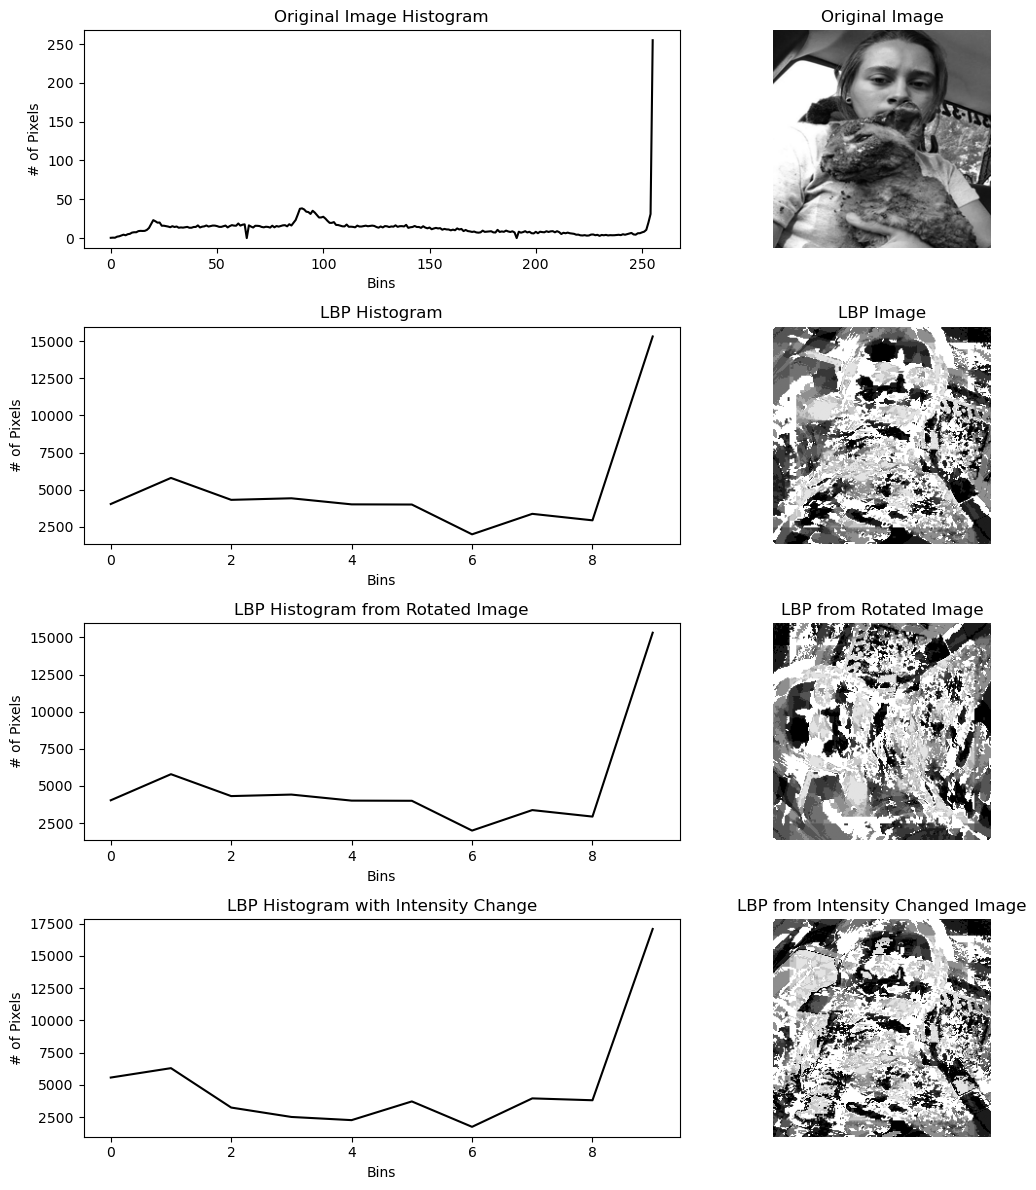

In [14]:
# using the same image we used with Color Histograms
test_im = cv2.normalize(cv2.cvtColor(test_img.astype(np.uint8), cv2.COLOR_BGR2GRAY), None, 0, 255, cv2.NORM_MINMAX)
hist = cv2.calcHist([test_im], [0], None, [256], [0, 256])
hist = cv2.normalize(hist, None, 0, 255, norm_type=cv2.NORM_MINMAX)

# use for-loop and indent everything below it to show how LBP works with different P and R values
# for p in [1, 2, 4, 8, 16]:
#     P = p
#     R = P*3

P = 8
R = P*3
bins = P + 2

hist_lbp = local_binary_pattern(test_im, P=P, R=R, method='uniform')
print(f"LBP Histogram for Test Image with P={P}, R={R}:")

# 128 bins to be more realistic b/c in a ML model, lots of hists with 256 bins is too many features
hist_np, _ = np.histogram(hist_lbp.ravel(), bins=bins, range=(0, bins))

fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# First row: original image histogram and test_im
axes[0, 0].plot(hist, color='black')
axes[0, 0].set_title('Original Image Histogram')
axes[0, 0].set_xlabel('Bins')
axes[0, 0].set_ylabel('# of Pixels')

axes[0, 1].imshow(test_im, cmap='gray')
axes[0, 1].set_title('Original Image')
axes[0, 1].axis('off')

# Second row: LBP image and LBP histogram
axes[1, 0].plot(hist_np, color='black')
axes[1, 0].set_title('LBP Histogram')
axes[1, 0].set_xlabel('Bins')
axes[1, 0].set_ylabel('# of Pixels')

axes[1, 1].imshow(hist_lbp, cmap='gray')
axes[1, 1].set_title('LBP Image')
axes[1, 1].axis('off')

# rotate image to show rotation invariance
test_im_rotated = np.rot90(test_im)
hist_lbp_rotated_im = local_binary_pattern(test_im_rotated, P=P, R=R, method='uniform')
hist_lbp_rotated_np, _ = np.histogram(hist_lbp_rotated_im.ravel(), bins=bins, range=(0, bins))

axes[2, 1].imshow(hist_lbp_rotated_im, cmap='gray')
axes[2, 1].set_title('LBP from Rotated Image')
axes[2, 1].axis('off')

axes[2, 0].plot(hist_lbp_rotated_np, color='black')
axes[2, 0].set_title('LBP Histogram from Rotated Image')
axes[2, 0].set_xlabel('Bins')
axes[2, 0].set_ylabel('# of Pixels')

# change greyscale intensity uniformly to show greyscale invariance
test_im_gs_changed = np.clip(test_im + 50, 0, 255).astype(np.uint8)
hist_lbp_gs_changed = local_binary_pattern(test_im_gs_changed, P=P, R=R, method='uniform')
hist_lbp_gs_changed_np, _ = np.histogram(hist_lbp_gs_changed.ravel(), bins=bins, range=(0, bins))

# uncomment to see px intensity differences
# Image.fromarray(test_im_gs_changed).show()
# Image.fromarray(test_im).show()

axes[3, 0].plot(hist_lbp_gs_changed_np, color='black')
axes[3, 0].set_title('LBP Histogram with Intensity Change')
axes[3, 0].set_xlabel('Bins')
axes[3, 0].set_ylabel('# of Pixels')

axes[3, 1].imshow(hist_lbp_gs_changed, cmap='gray')
axes[3, 1].set_title('LBP from Intensity Changed Image')
axes[3, 1].axis('off')

plt.tight_layout()
plt.show()

### Choosing the Best Combination of Features

To find out which of the above techniques or combination of techniques best promotes intra-class similarity and inter-class variance, we need to find all the possible combinations and test each of them out on the images using a distance metric on the resulting image matrices. The distance metric we will use is Euclidean distance. 
$$Euclidean\ Distance = |X - Y| = \sqrt{\sum_{i=1}^{i=n}(x_i - y_i)^2}$$

The code below shows the preliminary functions necessary to finding the best features. 

In [15]:
from itertools import combinations

# Function used to find all possible (unordered) combinations
def powerset_without_emptyset(items):
    '''
    Returns the powerset of a list of items as a list of tuples, excluding the empty set
    The powerset is the set of all subsets of a set 
    
    Example output
    powerset_without_emptyset([1, 2, 3])
    returns: [(1,), (2,), (3,), (1, 2), (1, 3), (2, 3), (1, 2, 3)]
    '''
    combos = []
    for i in range(len(items)):
        combos.extend(list(combinations(items, len(items) - i)))
    return combos

In [16]:
import cv2
import skimage.feature

# example transforms to use
transforms = [cv2.HuMoments, skimage.feature.graycomatrix, cv2.calcHist, skimage.feature.local_binary_pattern]
all_combos = powerset_without_emptyset(transforms)

# total number of combinations
len(all_combos)
all_combos[:5]  # Display the first 5 combinations


for combo in all_combos:
    if len(combo) == 1:
        print(f"Single transform: {combo[0].__name__}")

print(f'\nTotal number of combinations: {len(all_combos)}')

Single transform: HuMoments
Single transform: graycomatrix
Single transform: calcHist
Single transform: local_binary_pattern

Total number of combinations: 15


Now we have to test all 15 combinations on the CrisisMMD images. To do this, we will use contrastive loss that uses Euclidean Distance to compare results. The combination that results will be the lowest contrastive loss is the combination that best distinguishes classes. 

The formula for contrastive loss is: 
$$L = \sum_{i=1}^{P} L\left(W, (Y, X_1, X_2)^i\right)$$

$$L\left(W, (Y, X_1, X_2)^i\right) = (1 - Y) \, L_G\left(E_W(X_1, X_2)^i\right) + Y \, L_I\left(E_W (X_1, X_2)^i\right)$$ 

where $L_G$ is a loss function used for when the pairs are from the same class and $L_I$ is for when the pairs are not from the same class. 

This can then become:
$$
L = [y_i = y_j] \|f(x_i) - f(x_j)\|_2^2 + [y_i \neq y_j] \max\left(0, \varepsilon - \|f(x_i) - f(x_j)\|_2\right)^2
$$

That formula penalizes pairs of examples for being either too far apart (if in the same class) or too similar (if in different classes).

**Note**: the L2 norm (seen in the contrastive loss formula) is equivalent to Euclidean Distance. 

Sources: 
* https://lilianweng.github.io/posts/2021-05-31-contrastive/
*  Paper "Learning a Similarity Metric Discriminatively, with Application to Face
Verification" (Chopra et al. 2005): https://www.cs.utoronto.ca/~hinton/csc2535_06/readings/chopra-05.pdf




#### Custom Contrastive Loss Function

Below is an implementation of contrastive loss that we can use on pairs of images in order to see which transformations result in the most overall inter-class variance and intra-class similarity. It can also, potentially, be used to find which settings for the transformations are ideal. 

In [17]:
import torch
import torch.nn as nn
from sklearn.metrics.pairwise import nan_euclidean_distances

#TODO: find a way to further vectorize this function so you won't have to loop through each pair of images
class ContrastiveLossPairs(nn.Module): 
    def __init__(self, margin=.5):
        super(ContrastiveLossPairs, self).__init__()
        self.margin = margin
    
    
    def forward(self, pairs, labels):
        '''
        pairs - a tensor of shape (N, 2, F) where N is the number of pairs
        labels - a tensor of shape (N, 2) containing the labels of the images in the pairs
        '''
        pairs = pairs.squeeze()
        labels = labels.squeeze()
        
        X1 = pairs[:,0, :] # the first images per pair
        if X1.shape[0] == 0:
            print('ndarray X1 in ContrastiveLossPairs.forward() is size 0 (0 elements)')
            print(f'Shape of pairs is {pairs.shape}')
            return None
        
        X1 = X1.reshape(X1.shape[0], -1)

        X2 = pairs[:,1, :]
        X2 = X2.reshape(X2.shape[0], -1)

        labels1 = labels[:, 0]
        labels2 = labels[:, 1]

        # loss fn depends on whether the labels are the same or not
        # we divide the loss by the total num of features in the feature dim to best compare btw feature representations with differing feature dim sizes
        loss = (labels1==labels2).astype(np.float32) * np.linalg.norm(X1 - X2, axis=1)**2 / X1.shape[1] + \
        (labels1!=labels2).astype(np.float32) * (np.maximum(0, self.margin - np.linalg.norm(X1 - X2, axis=1))**2 / X1.shape[1])
        
        return loss.mean()*100 # multiply by 100 so the loss is not so small


Next, we need a way to pair the images up so we can use our contrastive class to compare them...

In [18]:
# make positive pairs so each image is paired with another image of the same class
from tqdm import tqdm

def make_pairs(labels):
    '''
    Returns two nested lists where the first list contains lists of two integer values each
    The first list contains indices of pairs of samples that are from the same class
    The second list contains indices of pairs of samples that are from different classes 
    '''
    
    pos_pairs = []
    neg_pairs = []
    for i in tqdm(range(len(labels)), desc='making index pairs...', total=len(labels)):
        for j in range(len(labels)):
            if i != j and labels[i] == labels[j] \
            and [i, j] not in pos_pairs and [j, i] not in pos_pairs:
                pos_pairs.append([i, j])

            elif i != j and labels[i] != labels[j] \
            and [i, j] not in neg_pairs and [j, i] not in neg_pairs:
                neg_pairs.append([i, j])


        if len(pos_pairs) == 0:
            print('No pairs from the same class found')
        elif len(neg_pairs) == 0:
            print('No pairs from different classes found')
        
    return pos_pairs, neg_pairs


from itertools import combinations, product

def make_pairs_fast(labels):
    '''
    Returns two nested lists where the first list contains lists of two integer values each
    The first list contains indices of pairs of samples that are from the same class
    The second list contains indices of pairs of samples that are from different classes 
    '''
    labels = np.array(labels)
    pos_pairs = []
    neg_pairs = []

    # Group indices by label
    label_to_indices = {}
    for idx, label in enumerate(labels):
        label_to_indices.setdefault(label, []).append(idx)

    # Positive pairs: all unique combinations within each label group
    for indices in label_to_indices.values():
        pos_pairs.extend(list(combinations(indices, 2)))

    # Negative pairs: all unique pairs between different label groups
    label_list = list(label_to_indices.keys())
    for i in range(len(label_list)):
        for j in range(i+1, len(label_list)):
            inds1 = label_to_indices[label_list[i]]
            inds2 = label_to_indices[label_list[j]]
            neg_pairs.extend(list(product(inds1, inds2)))

    return pos_pairs, neg_pairs

**Note**: In the example below, loss for positive pairs is 0 because all the positive pairs are equal to each other. Play around with the code to get a better understanding. 

In [19]:
contraster = ContrastiveLossPairs(margin=.5)


faux_ims = np.concatenate(
    (np.ones((5, 224, 224, 3)),
    np.ones((5, 224, 224, 3)))
)
faux_labels = np.concatenate(
    (np.ones(5), np.zeros(5))
)
# make pairs
pos_idxs, neg_idxs = make_pairs(faux_labels)
pos_idxs2, neg_idxs2 = make_pairs_fast(faux_labels)

assert(len(pos_idxs) == len(pos_idxs2))
print(pos_idxs)
print()
print(pos_idxs2)

# concat along dim 0
idxs = np.concatenate([pos_idxs, neg_idxs], axis=0)
ims_to_process = faux_ims[idxs]
labels_to_process = faux_labels[idxs]
# use contrastive loss 
loss = contraster.forward(ims_to_process, labels_to_process)

# the loss comes from how close 
print(f"Overall loss: {loss}")


making index pairs...: 100%|██████████| 10/10 [00:00<00:00, 9998.34it/s]

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4], [5, 6], [5, 7], [5, 8], [5, 9], [6, 7], [6, 8], [6, 9], [7, 8], [7, 9], [8, 9]]

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]
Overall loss: 9.226780990173849e-05


In [20]:
# the output above makes sense because the positive pairs will all result in loss=0
# and the 5 .5s from the negative pairs are only counted for half of the mean loss (10/5)
np.maximum(0, .5 - np.linalg.norm(1 - 1))**2 * .5

0.125

#### Applying Image Transformations

The next step is to apply the transformations to the images so that we can have a matrix of feature representation per group of tranformations, where each feature representation represents an image.  

**NOTE TO SELF**: these take in normalized images but do not normalize or flatten their output

In [21]:
#TODO: make these transformation functions more customizable
# TODO: change the transforms to these functions
# TODO: check if cv2.normalize converts imgs to greyscale - we do NOT want that for color hists

def apply_HuMoments(image):
    '''
    Computes and returns the Hu Moments of an image.
    Parameters:
    - image: a numpy array normalized to [0,255] representing the image
    Returns:
    - feat: an unnormalized numpy array of Hu Moments
    '''
    # Convert to grayscale if the image is RGB
    assert(image.ndim <= 3), "Image must be a 2D or 3D array"

    if image.ndim == 3:
        im_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        im_grey = image
    # compute moments
    feat = cv2.HuMoments(cv2.moments(im_grey)).flatten()

    return feat

# create kernels
def make_gabor_kernels(n_theta=4, sigma_range=(1,3), freq_range=(.05, .25)):
    
    kernels = []
    for theta in range(n_theta):
        # TODO: double check that theta is in range correct range
        theta = theta / n_theta * np.pi 
        for sigma in sigma_range:
            for freq in freq_range:
                kernel = np.real(
                    gabor_kernel(freq, theta=theta, sigma_x=sigma, sigma_y=sigma)
                )
                kernels.append(kernel)
    return kernels

def apply_Gabor(image):
    '''
    Parameters:
    - image: a numpy array normalized to [0,255] representing the image
    '''
    assert(image.ndim <= 3), "Image must be a 2D or 3D array"
    # convert to grayscale if the image is RGB
    if image.ndim == 3:
        im_grey = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        im_grey = image
    kernels = make_gabor_kernels()

    # normalize to [0,1] in preparation for ndi.convolve
    im_grey = cv2.normalize(im_grey, None, 0, 1, cv2.NORM_MINMAX)
    # compute features for each kernel
    feats = compute_gabor_feats(im_grey, kernels).flatten()

    return feats

def apply_colorHist(image):
    '''
    Parameters:
    - image: a numpy array normalized to [0,255] representing the image
    '''
    assert(image.ndim <= 3), "Image must be a 2D or 3D array"
    if image.ndim == 2:
        im_rgb = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else:
        im_rgb = image
    # compute color histogram  (256 is used b/c end of range is exclusive)
    hist = cv2.calcHist([im_rgb], channels=[0,1,2], mask=None, histSize=[8,8,8], ranges=[0,256]*3)

    return hist

def apply_LBP(image, radius, n_points, method='uniform'):
    assert(image.ndim <= 3), "Image must be a 2D or 3D array"
    im_grey = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY) if img.ndim == 3 else img
    
    lbp = skimage.feature.local_binary_pattern(im_grey, P=n_points, R=radius, method=method)

    # n_points + 2 is explained in the LBP tutorial I linked previously
    # .ravel() just explicitly flattens the array into a 1d view (b/c we don't need to modify the array after flattening)
    hist, _ = np.histogram(lbp.ravel(), density=True, bins=n_points+2, range=(0, n_points+2))
    return hist

In [22]:
from tqdm import tqdm

def apply_transformations(images, combo, shrink_by = 0):
    """
    Applies a combination of transformations to a list of images.
    Returns a 2D array of normalized feature representations: (num_images, total_feature_dim)
    """

    all_feats = []

    # apply each transformation in combo to each image
    for i in tqdm(range(images.shape[0]), desc="Processing images", total=images.shape[0]):
        img = images[i]
        assert img.shape == (224, 224, 3), "Image must be a 3D array with shape (224, 224, 3) or (224, 224)"
        # shrink image if specified
        if shrink_by > 0:
            if img.ndim == 2:
                shrink = (slice(0, None, shrink_by), slice(0, None, shrink_by))
            elif img.ndim == 3:
                shrink = (slice(0, None, shrink_by), slice(0, None, shrink_by), slice(None))
            else:
                raise ValueError(f"Unsupported image dimensions: {img.ndim}. Expected 2D or 3D array.")
            
            img = img[shrink]
            
        # ensure all imgs are in the same range 
        img = cv2.normalize(img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        img_feats = []

        assert img.shape == (224, 224, 3), "Image must be a 3D array with shape (224, 224, 3)"
        for t in combo:
            assert img.shape == (224, 224, 3), "Image must be a 3D array with shape (224, 224, 3)"
            if t is apply_HuMoments: 
                feat = apply_HuMoments(img)
            elif t is apply_Gabor:
                feat = apply_Gabor(img)
            elif t is apply_colorHist:
                feat = apply_colorHist(img)
            elif t is apply_LBP:
                temp_feats = []
                for p in [2, 4, 8]:
                    for r in [1, 2, 3]:
                        temp_feat = apply_LBP(img, radius=p*r, n_points=p, method='uniform')
                        temp_feats.append(temp_feat)
                feat = np.concatenate(temp_feats, axis=0)
            else: 
                print(t)
                raise ValueError(f'Unsupported transformation: {t}')
            
            # flatten to ensure that the feature is a 1D array
            # normalized to [0,1] as typically expected by a model
            feat = cv2.normalize(feat.flatten(), None, 0, 1, cv2.NORM_MINMAX)

            img_feats.append(feat)

        # 1 feature representation per image
        all_feats.append(np.concatenate(img_feats))
    
    
    all_feats = np.stack(all_feats)
    assert images.shape[0] == all_feats.shape[0], "implementation is wrong after stacking"

    return all_feats



In [23]:
from joblib import Parallel, delayed
def get_feature_reps(transformations, images, labels):
    '''
    Parameters:
    - transformations: a list (containing only unique names) of transformation functions to apply to the images
    - images: a 2D numpy array of shape (N, H, W, C) where N is the number of images, H is the height, W is the width, and C is the number of channels
    - labels: a 1D numpy array of shape (N,) containing the labels for each image

    Returns:
    - a list of dictionaries, each containing:
        - 'combo_name': a string representing the combination of transformations applied
        - 'feats': a 2D numpy array of shape (N, F) where N is the number of images and F is the size of the feature representation of each image
        - 'labels': a 1D numpy array of shape (N,) containing the labels
    '''
    assert images.shape[0] == labels.shape[0], "Number of images must match number of labels"
    
    dict_list = []
    
    combos = powerset_without_emptyset(transformations)
    

    feats_list = Parallel(n_jobs=-1)(
    delayed(apply_transformations)(images, combo, shrink_by=0)
    for combo in combos
)

    for combo, feats in zip(combos, feats_list):
        combo_name = '-'.join([t.__name__ for t in combo])
        dict_list.append({
            'combo_name': combo_name,
            'feats': feats,
            'labels': labels[0:feats.shape[0]]
        })

            
    assert len(dict_list) == len(combos), "dict_list length should match number of combos"
    assert all(dict_list[i]['feats'].shape[0] == images.shape[0] for i in range(len(dict_list))), "All feature representations should have the same number of images as input"
    assert all(dict_list[i]['labels'].shape[0] == images.shape[0] for i in range(len(dict_list))), "All labels should have the same number of images as input"
    
    return dict_list



##### Finding the best transformations to use

In [24]:
# get a list of images from the dataframe
train_imgs_paths = train_data['image'].tolist()
train_imgs_ls = [np.array(Image.open(dir / img_path).convert(mode='RGB').resize((224,224))) for img_path in train_imgs_paths]

# get a list of the labels from the dataframe
id2label = train_data['label_image'].value_counts().reset_index()['label_image'].to_dict()
label2id = {v: k for k, v in id2label.items()}
print(label2id)

train_labels = np.array([label2id[label] for label in train_data['label_image'].tolist()])

# join ndarray imgs along new axis (0)
train_imgs = np.stack(train_imgs_ls)

train_imgs.shape, train_labels.shape

c:\Users\bowdenaa\AppData\Local\anaconda3\envs\torch\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


{'not_humanitarian': 0, 'infrastructure_and_utility_damage': 1, 'other_relevant_information': 2, 'rescue_volunteering_or_donation_effort': 3, 'affected_individuals': 4, 'vehicle_damage': 5, 'injured_or_dead_people': 6, 'missing_or_found_people': 7}


((13608, 224, 224, 3), (13608,))

In [25]:
# UNCOMMENT BELOW IF YOU NEED TO RE-CREATE THE DICTIONARY CONTAINING FEATURES

# import datetime 
# import pickle
# # for each transformation, get the feature representations of the images and the labels
# transforms = [apply_colorHist, apply_Gabor, apply_HuMoments, apply_LBP]

# # input rgb imgs 
# dict_list = get_feature_reps(transforms, images=train_imgs, labels=train_labels)

# today = datetime.datetime.now().strftime("%Y-%m-%d")

# with open(f'dict_list_{today}.pkl', 'wb') as f:
#     pickle.dump(dict_list, f, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
import pickle 

with open('dict_list_2025-07-11', 'rb') as f:
    dict_list = pickle.load(f)


In [27]:
dict_list[0]['feats'].shape, dict_list[0]['labels'].shape, dict_list[0]['combo_name']

((13608, 643, 1),
 (13608,),
 'apply_colorHist-apply_Gabor-apply_HuMoments-apply_LBP')

In [28]:
for dct in dict_list:
    for k in dct.keys():
        if k != 'combo_name':
            dct[k] = dct[k].astype(np.float32)

In [29]:
# remember: loss function takes in (N, 2, F) and (N, 2) np arrays 

def loss_from_combo(feats, labels, contraster, pairs_idxs):
    assert type(feats) == np.ndarray and type(labels) == np.ndarray
    # print(type(pairs_idxs))
    # get first from each pair
    idxs1 = [pair[0] for pair in pairs_idxs]
    # print(idxs1)
    # second from each pair
    idxs2 = [pair[1] for pair in pairs_idxs]

    feats_to_process1 = feats[idxs1]
    # print(feats_to_process1.shape)
    feats_to_process2 = feats[idxs2]
    labels_to_process1 = labels[idxs1]
    labels_to_process2 = labels[idxs2]

    feats_to_process = np.stack([feats_to_process1, feats_to_process2], axis=1)
    labels_to_process = np.stack([labels_to_process1, labels_to_process2], axis=1)

    # print(feats_to_process.shape, labels_to_process.shape)
    assert feats_to_process.shape[1:3] == (2, feats.shape[1]), 'the feats to be input into the loss fn are the wrong shape'
    # print(labels_to_process.shape)
    assert labels_to_process.shape == (feats_to_process.shape[0], 2), 'the labels to be input into the loss fn are the wrong shape'

    loss = contraster(pairs=feats_to_process, labels=labels_to_process)

    return loss
    

In [30]:
def get_loss_from_combos(dict_list, batch_idx=None):
    loss_list = []
    contraster = ContrastiveLossPairs(margin=.5)

    pos_pairs, neg_pairs = make_pairs_fast(dict_list[0]['labels']) # labels are always the same for all the dictionaries
    pair_idxs = np.concatenate([pos_pairs, neg_pairs], axis=0)
    assert(len(pair_idxs) == len(pos_pairs) + len(neg_pairs))

    for dct in tqdm(dict_list, desc='Processing combos', total=len(dict_list)):
        loss = loss_from_combo(dct['feats'], dct['labels'], 
                               contraster, pairs_idxs=pair_idxs)
        if loss == None and batch_idx:
            print(f'Loss computation error for {dct['combo_name']} at batch idx {batch_idx}')

        loss_dict = {}
        loss_dict['combo_name'] = dct['combo_name']
        loss_dict['loss'] = loss

        loss_list.append(loss_dict)

    
    return loss_list

In [31]:
def batch_dicts(dict_list, batch_size = 128):
    '''
    Returns: 
        a list of dict_lists, where there are batch_size images and labels per dictionary
    '''
    feats_len = dict_list[0]['feats'].shape[0]
    full_batches = feats_len // batch_size

    batch_dicts = []

    for b in range(full_batches):
        one_batch = []
        for dct in dict_list:
            # so if b=0, get feats 0:128; if b=1, get feats 128:256, and so on
            feats = dct['feats'][b*batch_size:(b+1)*batch_size]
            labels = dct['labels'][b*batch_size:(b+1)*batch_size]
            name = dct['combo_name']
            
            one_batch.append({
                'combo_name': name, 
                'feats': feats,
                'labels': labels
            })
        batch_dicts.append(one_batch)
    
    last_batch = []
    for dct in dict_list:
        feats = dct['feats'][full_batches*batch_size : ]
        labels = dct['labels'][full_batches*batch_size : ]
        name = dct['combo_name']

        last_batch.append({
            'combo_name': name, 
            'feats': feats,
            'labels': labels
        })
    
    if len(last_batch) > 0:
        batch_dicts.append(last_batch)


    
    return batch_dicts

In [32]:
## UNCOMMENT IF YOU DON'T HAVE THE COMBO LOSS LIST PICKLE FILE

# assert dict_list[0]['feats'].dtype == np.float32

# batched_dicts = batch_dicts(dict_list, batch_size = 256) 


# loss_lists = []
# for b, batch in enumerate(batched_dicts):
#     loss_list = get_loss_from_combos(batch, batch_idx=b)
#     loss_lists.append(loss_list)

# # create final list of losses
# # first, set up the dictionaries with combo_name the same but loss=0 for all dicts
# final_loss_list = []
# for dct in loss_lists[0]: # doesn't matter what index of loss_lists we use bc we just want the combo_names
#     new_dct = {}
#     new_dct['combo_name'] = dct['combo_name']
#     new_dct['loss'] = 0

#     final_loss_list.append(new_dct)

# for lst in loss_lists:
#     for dct1 in lst:
#         for dct2 in final_loss_list:
#             if dct1['combo_name'] == dct2['combo_name']:
#                 if dct1['loss'] is not None:
#                     dct2['loss'] += dct1['loss']
#                 break # break inner loop b/c each dct1 will only have one match in final_loss_list


# for dct in final_loss_list:
#     total = 0
#     count = 0
#     for lst in loss_lists:
#         for dct1 in lst:
#             if dct1['combo_name'] == dct['combo_name'] and dct1['loss'] is not None:
#                 total += dct1['loss']
#                 count += 1
#     dct['loss'] = total / count if count > 0 else None


# with open('combo_loss_list.pkl', 'wb') as f:
#     pickle.dump(final_loss_list, f, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
with open('combo_loss_list.pkl', 'rb') as f:
    final_loss_list = pickle.load(f)

##### Best Transformations Results
Below, we see that the combination of transformations that best distinguishes between classes while promoting intra-class similarity is one that applies Gabor filters, HuMoments, and LBPs. 

In [34]:

best_combo, best_loss = None, np.inf
for dct in final_loss_list:
    print(f"combo: {dct['combo_name']}, loss: {dct['loss']}")
    if dct['loss'] < best_loss:
        best_loss = dct['loss'] 
        best_combo = dct['combo_name']

print(f'\nBEST COMBO: {best_combo}, LOSS: {best_loss}')


combo: apply_colorHist-apply_Gabor-apply_HuMoments-apply_LBP, loss: 0.170035444467363
combo: apply_colorHist-apply_Gabor-apply_HuMoments, loss: 0.18753480269677109
combo: apply_colorHist-apply_Gabor-apply_LBP, loss: 0.17188561377460482
combo: apply_colorHist-apply_HuMoments-apply_LBP, loss: 0.18883037954327409
combo: apply_Gabor-apply_HuMoments-apply_LBP, loss: 0.13046837239353745
combo: apply_colorHist-apply_Gabor, loss: 0.18979036572596264
combo: apply_colorHist-apply_HuMoments, loss: 0.21066048324832487
combo: apply_colorHist-apply_LBP, loss: 0.19111756981281494
combo: apply_Gabor-apply_HuMoments, loss: 0.24072333752108668
combo: apply_Gabor-apply_LBP, loss: 0.13778092020570679
combo: apply_HuMoments-apply_LBP, loss: 0.25509487863423097
combo: apply_colorHist, loss: 0.21351416146865598
combo: apply_Gabor, loss: 0.2669505421417179
combo: apply_HuMoments, loss: 2.4416223996215396
combo: apply_LBP, loss: 0.28474725118872746

BEST COMBO: apply_Gabor-apply_HuMoments-apply_LBP, LOSS: 0.13

## Feature Engineering - Deep Features

To extract "deep" features from images, we will run our CrisisMMD images through a deep CNN. The CNN we use is VGG16, pretrained on images from the Places365 dataset. 

We use the Places365 dataset because it is used for scene recognition tasks, and the important disaster-related images are often complex scenes containing different objects and people. 

**Credit**: the downloadable weights can be found [here](https://github.com/GKalliatakis/Keras-VGG16-places365#) and are converted to Pytorch-compatible format by first converting the Tensorflow model to ONNX format. See tutorial [here](https://www.geeksforgeeks.org/deep-learning/how-to-convert-a-tensorflow-model-to-pytorch/). 

##### Conversion
Skip this section unless you are interested in converting the TF model to Pytorch. 

**Note**: After converting the formats, the output of the models was tested using randomly generated using inputs created from torch.randn and tf.rand.normal. The cosine similarity between the flattened output was .9983, strongly supporting that the conversion was successful. 

**Note from [documentation](https://github.com/CSAILVision/places365/tree/master?tab=readme-ov-file)**: "note that the **input image scale should be from 0-255**, which is different to the 0-1 scale in the previous resnet Torch models trained from scratch in fb.resnet.torch."
* so, do not use any functions for preprocessing that scale to [0,1] without multiplying by 255 after

In [35]:
# # Uncomment the following lines to convert the Keras model to ONNX format

# import tf2onnx
# import onnx
# import tensorflow as tf 
# import os
# from pathlib import Path
# import pickle

# home = os.path.expanduser('~')
# this_dir = (Path(home) / 'SURE-2025')

# vgg16_path = Path(this_dir) / 'vgg16' 
# os.chdir(vgg16_path)
# from vgg16_places_365 import VGG16_Places365

# os.chdir(this_dir)

# tf_model = VGG16_Places365() # 'places' weights are used by default 

# tf_model.build(input_shape=(None, 224, 224, 3)) # build the model with the input shape
# out = tf_model.call(tf.random.normal(shape=(1, 224, 224, 3))) # call the model to initialize it

# tf_out = out.numpy() # convert the output to a numpy array


# # convert the Keras model to ONNX format
# tf2onnx.convert.from_keras(tf_model, output_path=Path('vgg16', 'vgg16_places_365.onnx'), opset=13)

# # save the output to a file for later comparison
# with open(vgg16_path / 'tf_out.pkl', 'wb') as f:
#     pickle.dump(tf_out, f)

In [36]:
import onnx
model = onnx.load("vgg16/vgg16_places_365.onnx")
onnx.checker.check_model(model)
print("ONNX model loaded successfully!")

ONNX model loaded successfully!


In [37]:
# from onnx2pytorch import ConvertModel
# from pathlib import Path
# import torch

# torch_model = ConvertModel(onnx.load(Path('vgg16', 'vgg16_places_365.onnx')))
# assert isinstance(torch_model, torch.nn.Module), "Converted model is not a PyTorch module"
# # save entire model 
# torch.save(torch_model, Path('vgg16', 'pytorch' 'vgg16_places_365.pth'))

In [38]:

# test_in = torch.randn(1, 224, 224, 3) # a random input tensor
# with torch.no_grad():
#     pt_out = torch_model(test_in)

# pt_out = pt_out.cpu().numpy()  # convert the output to a numpy array

In [39]:
# # compute cosine similarity between the outputs of the TensorFlow and PyTorch models
# import pickle

# from scipy.spatial.distance import cosine
# tf_out = pickle.load(open(Path('vgg16') / 'tf_out.pkl', 'rb'))  # load the TensorFlow output
# cosine_similarity = 1 - cosine(tf_out.flatten(), pt_out.flatten())
# print(f"Cosine similarity between TensorFlow and PyTorch outputs: {cosine_similarity:.4f}")

##### Feature Extraction

In [40]:
# load pretrained vgg16 model
deep_model = torch.load('vgg16/pytorchvgg16_places_365.pth')

C:\Users\bowdenaa\AppData\Local\Temp\ipykernel_20312\1206125936.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deep_model = torch.load('vgg16/pytorchvgg16_places_365.pt

In [41]:
# The name argument in get_features() specifies the dictionary key under which we will store our intermediate activations
def get_features(name):
    def hook(model, input, output):
        assert isinstance(output[0], torch.Tensor), "Hook output is not a tensor"
        assert output[0].dtype == torch.float32, "Hook output is not a float32 tensor"
        
        # return the pooled output b/c this specific model has return_indices=True
        # so output is a tuple of (pooled_output, indices)
        features[name] = output[0].detach()
        # print(f'hook output type is {type(output)}')
    return hook

In [42]:
# show features so we know what to register the hook on
i=0
pool_layers_names = {}
for name, layer in deep_model.named_modules():
    if isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
        # print(f"Layer: {name}, Type: {type(layer)}")
        pool_layers_names[f'pool{i+1}'] = (name, layer)
        i += 1

pool_layers_names
    

{'pool1': ('MaxPool_vgg16-places365/block1_pool/MaxPool:0',
  MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)),
 'pool2': ('MaxPool_vgg16-places365/block2_pool/MaxPool:0',
  MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)),
 'pool3': ('MaxPool_vgg16-places365/block3_pool/MaxPool:0',
  MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)),
 'pool4': ('MaxPool_vgg16-places365/block4_pool/MaxPool:0',
  MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)),
 'pool5': ('MaxPool_vgg16-places365/block5_pool/MaxPool:0',
  MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False))}

In [43]:
# change pooling layer names to use Python ref names
    # e.g. block1_pool is the new name/reference for the first pooling layer
deep_model.block1_pool = deep_model._modules[pool_layers_names['pool1'][0]]
deep_model.block2_pool = deep_model._modules[pool_layers_names['pool2'][0]]
deep_model.block3_pool = deep_model._modules[pool_layers_names['pool3'][0]]
deep_model.block4_pool = deep_model._modules[pool_layers_names['pool4'][0]]
deep_model.block5_pool = deep_model._modules[pool_layers_names['pool5'][0]]

# Note: the only immutable types in Python are: int, float, complex, bool, str, tuple, frozenset, bytes

In [44]:
# register hooks
layer_refs = [deep_model.block1_pool, deep_model.block2_pool,
 deep_model.block3_pool, deep_model.block4_pool, deep_model.block5_pool]

for i, ref in enumerate(layer_refs):
    ref.register_forward_hook(get_features(f'block{i+1}_pool'))

In [45]:
for i, (name, layer) in enumerate(deep_model.named_modules()):
    count = 0
    if isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
        layer.register_forward_hook(get_features(f'block{count+1}_pool'))
        count += 1

[VGG16 architecture info](https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918)

In [46]:
features = {}
def extract_deep_features(model, images, device, block_names):
    images = images.to(device, dtype=torch.float32)
    with torch.no_grad():
        features.clear()  # Clear once before forward pass
        preds = model(images)  # Run model once, hooks populate features
        FEATS = []
        dct = {}
        for name in block_names:
            if name not in features.keys():
                raise ValueError(f"Block name '{name}' not found in features dictionary. Available keys: {list(features.keys())}")
            temp_feats = features[name]
            assert isinstance(temp_feats, torch.Tensor)
            assert temp_feats.dtype == torch.float32
            
            temp_feats = torch.mean(temp_feats, dim=(2, 3)) # global avg pooling to keep dimensions manageable

            dct[name] = temp_feats
        FEATS.append(dct)
    PREDS = preds.cpu().numpy()
    assert len(FEATS) == len(images)
    return PREDS, FEATS

In [47]:
def preprocess_image(image):
    '''
    Preprocesses a 3d ndarray image for input into the model.
    Normalizes the images to [0, 255] and converts them to a tensor.
    '''
    im = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    im = torch.tensor(im, dtype=torch.float32)
    assert im.ndim == 3
    if im.shape[0] == 3:
        im = im.permute(1, 2, 0)
    
    return im

In [48]:
from torch.utils.data import Dataset, DataLoader

class CustomImgDataset(Dataset):
    def __init__(self, images, labels, preprocess_fn=None):
        assert len(images) == len(labels), "Number of images must match number of labels"
        self.images = images
        self.labels = labels
        self.preprocess_fn = preprocess_fn
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.preprocess_fn:
            image = self.preprocess_fn(image)
        
        return image, label


In [49]:
batch_size_deep = 1
trainset = CustomImgDataset(train_imgs, train_labels, preprocess_fn=preprocess_image)
trainloader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)

In [50]:
trainset.__getitem__(0)[0].shape

torch.Size([224, 224, 3])

In [51]:
# feature extraction time!


block_names = ['block1_pool', 'block3_pool', 'block5_pool']

# UNCOMMENT IF YOU NEED TO EXTRACT FEATURES (don't have .pkl file)

# deep_model = deep_model.to(device)
# deep_model.eval() 

# PREDS = []
# FEATS = []
# if batch_size_deep == 1:
#     for item in tqdm(trainloader, 
#                      desc='Processing images for feature extraction', 
#                      total=len(trainloader)):
#         image, label = item
#         images = image.to(device)
#         preds, feats = extract_deep_features(deep_model, images, device, block_names=block_names)
#         PREDS.append(preds)
#         FEATS.append(feats)
# else:
#     print('Warning: batch size > 1. Use a different implementation.')



# # getting features as a numpy array of shape (N, F)

# feats_per_img = []
# for dct in FEATS:
#     dct_feats = []
#     for name in block_names:
#         temp_feats = dct[0][name]
#         temp_feats = temp_feats.cpu().numpy()
#         dct_feats.append(temp_feats)
#     feats_per_img.append(np.concatenate(dct_feats, axis=1))

# feats_per_img = np.concatenate(feats_per_img, axis=0)

# PREDS = np.concatenate(PREDS, axis=0)

# with open('preds_and_features.pkl', 'wb') as f:
#     pickle.dump((PREDS, feats_per_img), f, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
with open('preds_and_features.pkl', 'rb') as f:
    PREDS, DEEP_FEATS = pickle.load(f)
PREDS.shape, DEEP_FEATS.shape

((13608, 365), (13608, 1280))

## Feature Fusion and Reduction

In the feature-fusion step, we concatenate together the traditional and deep features--one feature vector for each image. Concatenation was shown by this paper [insert link] to be the best operation to use for feature fusion. 

**Note**: PCA works best with mean = 0, standard deviation = 1

In [53]:


def fuse_features(trad_feats, deep_feats):
    '''
    Parameters: 
    - trad_feats: an ndarray of shape (N, F) where N is the num of images and F is the feature dimension
    - deep_feats: an ndarray of shape (N, F) where N is the num of images and F is the feature dimension
    Returns:
        an ndarray of shape (N, F) normalized to [0,1], where N is the number of images and F is the total number of features (traditional + deep)
    '''
    # concat along axis 1 because axis 0 is the batch size and we want to concatenate features for each image
    # dim=1 is the feature dimension
    fusion = np.concatenate((trad_feats, deep_feats), axis=1)

    return fusion

In [54]:
TRAD_FEATS = []
for dct in dict_list:
    if dct['combo_name'] == best_combo:
        TRAD_FEATS.append(dct['feats'])
        best_trad_dict = dct
TRAD_FEATS = np.concatenate(TRAD_FEATS, axis=0).squeeze()
assert TRAD_FEATS.shape[0] == DEEP_FEATS.shape[0], "Traditional and deep features must have the same number of images"

TRAD_FEATS.shape, DEEP_FEATS.shape

((13608, 131), (13608, 1280))

Below, we create two arrays of features. One contains the traditional ML features created from the best combination of transformations and the deep features extracted from the first, third, and fifth pooling layers. 

The second array contains both of those feature types, as well as the prediction information from the VGG16's Softmax classification layer. We will test both of them to see if including the prediction information aids the final classification. 

**Note**: By zooming into a png of the matrix, you better see the individual feature points. 

In [55]:
# fuse traditional and deep features 
fused_deep_trad = fuse_features(TRAD_FEATS, DEEP_FEATS)

# make an array that includes traditional, deep, and Places365 prediction information
fused_deep_trad_preds = fuse_features(fused_deep_trad, PREDS)

### Principal Component Analysis (PCA)

Let's start by ensuring that PCA is even a good choice. By making a correlation matrix, we can see if there is any relation between our features. We have a lot of initial features, especially after concatenating the traditional and deep features, so we just pay attention to the colors. Dark blue represents a strong positive correlation, and dark red represents a strong negative correlation. 

There are definitely strong relationships between some of the features (especially positive). This means that PCA can help us because if there are strongly correlated features, we can represent some features with others. However, many features are not heavily correlated with others, so we will still likely end up with more than 100 features. 

c:\Users\bowdenaa\AppData\Local\anaconda3\envs\torch\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\bowdenaa\AppData\Local\anaconda3\envs\torch\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


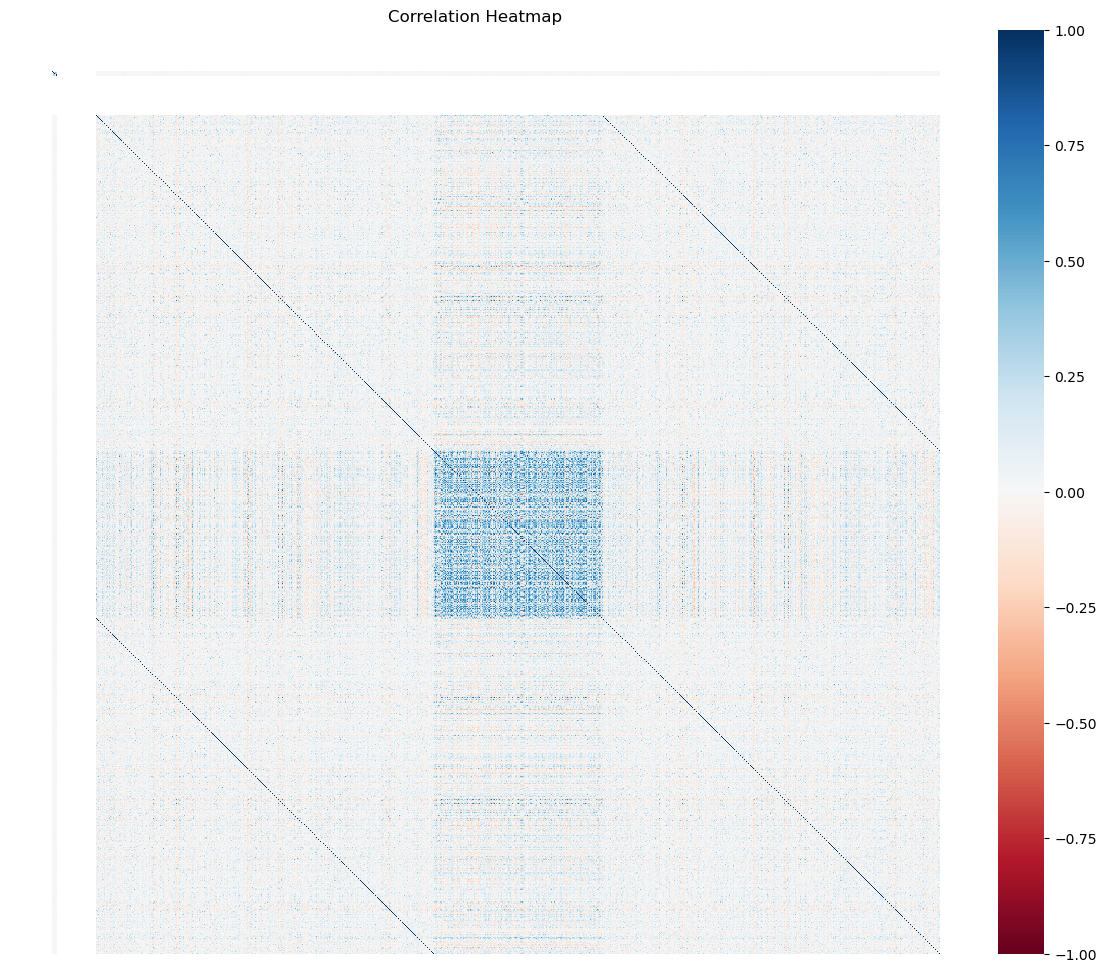

In [66]:
import seaborn as sns

# we have > 1000 raw features, so it takes a while
correlation = np.corrcoef(fused_deep_trad, rowvar=False) # rowvar=False means that each row represents a variable and each column represents an observation - IMPORTANT
plt.figure(figsize=(15, 12))
plt.axis('off')  # Hide the axes
sns.heatmap(correlation,
            cmap="RdBu",
            vmin=-1,
            vmax=1,
            annot=False)
plt.title("Correlation Heatmap")
# plt.savefig('correlation_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

#### Using Traditional + Deep Features

PCA can be used as a feature reduction technique when you want to choose the features that result in **maximum variance**. It aims to reduce the feature space as much as possible while maintaining the most meaningful information. 

[IBM PCA Tutorial](https://developer.ibm.com/tutorials/awb-reducing-dimensionality-with-principal-component-analysis/?sf185562769=1)

[Tutorial for PCA and choosing n_components parameter](https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis)

First, we run PCA on our data with n_components as either the number of features per sample ***or***--if we have a lot of features--as a reduced but still large amount of features (more features than we would want to run through the final classifier).

In [256]:
from sklearn.preprocessing import StandardScaler
# apply PCA to scaled features 

from sklearn.decomposition import PCA

def apply_PCA(features, n_components):
    pca = PCA(n_components=n_components, svd_solver='auto')

    # mean=0, std=1 
    normalized_feats = StandardScaler().fit_transform(features)
    
    X_out = pca.fit_transform(normalized_feats)

    return X_out, pca

In [257]:
n_components = len(fused_deep_trad[1]) // 2
principle_components, my_PCA = apply_PCA(fused_deep_trad, n_components=n_components)
pca_df = pd.DataFrame(principle_components, columns=[f'PC_{i+1}' for i in range(n_components)])
pca_df['label'] = pd.Series(train_labels).map(id2label)

In [258]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_697,PC_698,PC_699,PC_700,PC_701,PC_702,PC_703,PC_704,PC_705,label
0,-6.483407,-1.458812,-4.377675,0.782695,-2.691867,3.040298,-4.544667,-0.246070,-8.392500,-3.971657,...,0.106826,-0.064525,-0.004824,-0.030496,0.072127,-0.095187,0.051541,0.150211,0.117107,not_humanitarian
1,-4.279229,-10.293611,-1.826928,10.082675,-8.612285,0.966952,0.373369,7.567396,-8.787580,-1.048253,...,0.011217,-0.091922,-0.017748,0.034054,-0.053755,0.133823,0.053962,0.210282,-0.081365,infrastructure_and_utility_damage
2,0.922590,2.794921,5.278651,-5.355243,-5.791606,-0.180416,-5.681330,-3.382237,-2.256568,-4.639076,...,-0.094869,-0.136755,-0.068443,0.111611,-0.042198,-0.030788,0.071708,-0.017110,-0.065963,infrastructure_and_utility_damage
3,-1.346319,-4.895534,-6.283290,-2.690505,4.768451,3.136256,4.350184,1.188325,5.544921,-1.909333,...,-0.190312,-0.022432,0.004983,0.006354,-0.022283,0.001646,-0.088235,-0.115400,0.020491,infrastructure_and_utility_damage
4,5.079683,-9.692131,-9.456136,5.391883,3.800241,-2.725923,-5.270321,-4.021653,-2.687881,3.437037,...,-0.133992,-0.080224,-0.100021,0.124066,-0.009690,0.106725,-0.200983,-0.108326,-0.070621,infrastructure_and_utility_damage


Let's plot the first two principal components (the components that account for the first and second most amount of variance, respectively) against each other. We can also use a loop to plot up to a certain number of principal components. 

In [259]:
# color palette to help with visualization
from matplotlib.colors import ListedColormap
hex_codes = ["#ba81fa", "#ff0400", "#ff6600", '#ffec3d', "#ffa2f7", '#ff3d9e', '#fea88b', "#e73dfd"]

pallette = ListedColormap(hex_codes)

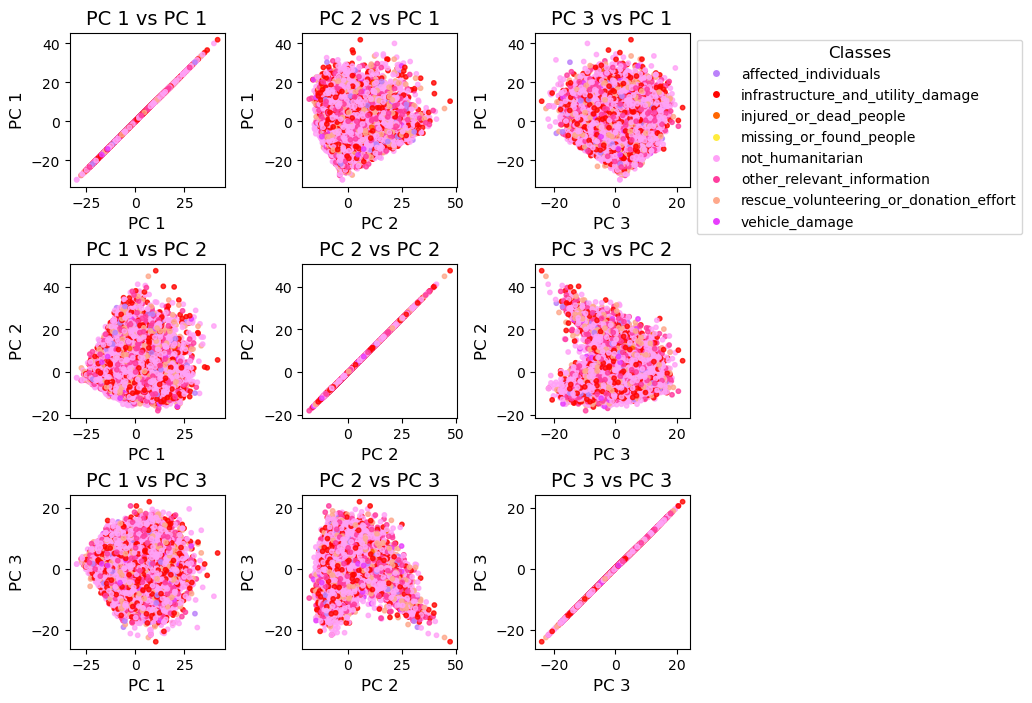

In [260]:
# scatter plot
# visualize relationships between first 4 principal components by class

n_pcs = 3
fig, axes = plt.subplots(n_pcs, n_pcs, figsize=(8, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # more space for labels/titles

plot_cat = pca_df['label'].astype('category')
plot_codes = plot_cat.cat.codes
plot_labels = plot_cat.cat.categories

for i in range(n_pcs):
    for j in range(n_pcs):
        ax = axes[i, j]
        ax.scatter(
            pca_df[f'PC_{j+1}'], pca_df[f'PC_{i+1}'],
            c=plot_codes, s=10, alpha=0.8, cmap=pallette
        )
        ax.set_xlabel(f'PC {j+1}', fontsize=12)
        ax.set_ylabel(f'PC {i+1}', fontsize=12)
        ax.set_title(f'PC {j+1} vs PC {i+1}', fontsize=14)
        # Only add legend to the top-right subplot
        if i == 0 and j == n_pcs-1:
            ax.legend(
                handles=[
                    plt.Line2D([0], [0], marker='o', color='w', label=label,
                               markerfacecolor=pallette(k), markersize=6)
                    for k, label in enumerate(plot_labels)
                ],
                title='Classes', loc='upper left',
                bbox_to_anchor=(1, 1),
                fontsize=10, title_fontsize=12
            )

plt.show()



The scatterplots are interesting, but not very useful for knowing how many features to retain. Below, you can see a scree plot. The scree plot "elbows" around n_component=50. So perhaps the number of features we keep can be 50. However, there can be multiple "elbows" in a scree plot, and the elbows can be hard to see with many n_components in the visualization. 

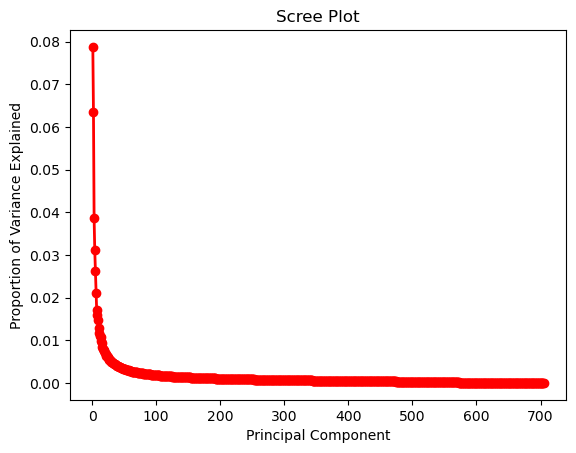

In [261]:
# scree plot / elbow plot
PC_values = np.arange(my_PCA.n_components_) + 1
plt.plot(PC_values, my_PCA.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()


We could also pick our n_components based on the Kaiser rule, which states that we should keep all components where the eigenvalue is greater than 1. Let's see how many n_components that would be:

In [262]:
# eigenvalues of the first 25 principal components
to_keep_kaiser = 0
for i, eigenval in enumerate(my_PCA.explained_variance_):
    if eigenval > 1:
        to_keep_kaiser += 1
    else:
        break
print(f'Number of principal components to keep based on the Kaiser rule: {to_keep_kaiser}')


Number of principal components to keep based on the Kaiser rule: 264


Finally, we could keep the number of components that explain a `threshold` percentage of the variance in the data. 

In [ ]:
# the nth value == total variance explained by the nth principal component
threshold = .7
to_keep_from_thres = 0
# np.cumsum adds values of input so the first value is the first ratio, the second value is the sum of the first two ratios, and so on
for i, eigenval in enumerate(np.cumsum(my_PCA.explained_variance_ratio_, axis=0)):
    if eigenval <= threshold:
        to_keep_from_thres += 1
    else:
        break
print(f'Number of principal components to keep based on the threshold of {threshold}: {to_keep_from_thres}')

Number of principal components to keep based on the threshold of 0.7: 119


### Linear Discriminant Analysis (LDA) using Traditional + Deep Features

LDA is similar to PCA but is specifically used to find the features that promote **class separability**. 

[IBM LDA tutorial](https://developer.ibm.com/tutorials/awb-implementing-linear-discriminant-analysis-python/)

[Other LDA tutorial](https://machinelearningmastery.com/linear-discriminant-analysis-for-dimensionality-reduction-in-python/)

In [ ]:
# explore data/features

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def apply_LDA(features, n_components=...):
    normalized_feats = cv2.normalize(features, None, 0, 1, cv2.NORM_MINMAX)
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    # TODO: make sure this is correct for dim reduction
    X_out = lda.fit_transform(normalized_feats)

    return X_out

## Classification - Random Forest Model